# Earthquake seismology with DAS

See Figure 5 from Ajo-Franklin et al 2019:
https://www.nature.com/articles/s41598-018-36675-8

<!-- ![image.png](attachment:image.png) -->

In [1]:
import h5py
import matplotlib.pyplot as plt
# %matplotlib notebook
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
import pandas as pd

import matplotlib.dates as mdates

from dasquakes import sintela_to_datetime, open_sintela_file, get_file_number

import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

pth ='/data/data0/seadasn/'
title=''

# Default filter parameters: Good for teleseisms
low_cut = 0.05
hi_cut = 1

chmin = 40
chanmax = 100

file_base_name = 'seadasn'

# M 6.7 - 58 km WSW of Masachapa, Nicaragua
### 2022-04-21 07:42:46 (UTC)11.554°N 86.992°W25.3 km depth

http://ds.iris.edu/wilber3/find_stations/11552089
https://earthquake.usgs.gov/earthquakes/eventpage/us6000hf75/executive

In [2]:
# title = 'mww6.7 Near Coast Of Nicaragua'

# t0 = datetime.datetime(2022,4,21,7,42,0)
# file_duration = 1
# dt = datetime.timedelta(minutes=file_duration)
# number_of_files = 50
# low_cut = 0.04
# hi_cut = 0.1

# 2022-03-16 Japan M7.1
http://ds.iris.edu/wilber3/find_stations/11540109

In [3]:
file_base_name = 'convert-to-hdf5'
# sample_rate = 533.33

t0 = datetime.datetime(2022,3,16,14,46,0)
number_of_files = 4
dt = datetime.timedelta(minutes=number_of_files)

low_cut = 0.05
hi_cut = 1

# 2022-03-30 New Caledonia M 6.9
http://ds.iris.edu/wilber3/find_stations/11544990

In [4]:
# t0 = datetime.datetime(2022,3,30,21,9,0)
# dt = datetime.timedelta(minutes=1)
# number_of_files = 60
# file_duration = 1

# 2022-03-31 New Caledonia M 7.0

In [5]:
# t0 = datetime.datetime(2022,3,31,5,44,0)
# dt = datetime.timedelta(minutes=1)
# number_of_files = 75
# file_duration = 1

In [6]:
data,dates,attrs = open_sintela_file(file_base_name,t0,pth,
                                    number_of_files=number_of_files)
x_max=data.shape[1] * attrs['SpatialSamplingInterval']

File problem with: /data/data0/seadasn/convert-to-hdf5_2022-03-16_14-49-00_UTC_000585.h5
Unable to open file (unable to open file: name = '/data/data0/seadasn/convert-to-hdf5_2022-03-16_14-49-00_UTC_000585.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


In [7]:
b,a = butter(2,(low_cut,hi_cut),'bp',fs=attrs['MaximumFrequency']*2)
data_filt = filtfilt(b,a,data,axis=0)

In [8]:
client = Client("IRIS")

t1 = UTCDateTime( t0.strftime("%Y-%m-%dT%H:%M:%S") )
dt = datetime.timedelta(minutes=number_of_files)
t2 = UTCDateTime( (t0+dt).strftime("%Y-%m-%dT%H:%M:%S") )

st = client.get_waveforms("UW", "NOWS", "--", "HNN", t1, t2, attach_response=True)
st.decimate(5, strict_length=False, no_filter=True)
#everything should be at 40Hz now
st2 = client.get_waveforms("IU", "COR", "00", "BH1", t1, t2, attach_response=True)

pre_filt = (low_cut/2, low_cut, hi_cut, hi_cut*2)
st.remove_response(output='VEL', pre_filt=pre_filt)
st2.remove_response(output='VEL', pre_filt=pre_filt)

1 Trace(s) in Stream:
IU.COR.00.BH1 | 2022-03-16T14:46:00.019538Z - 2022-03-16T14:49:59.994538Z | 40.0 Hz, 9600 samples

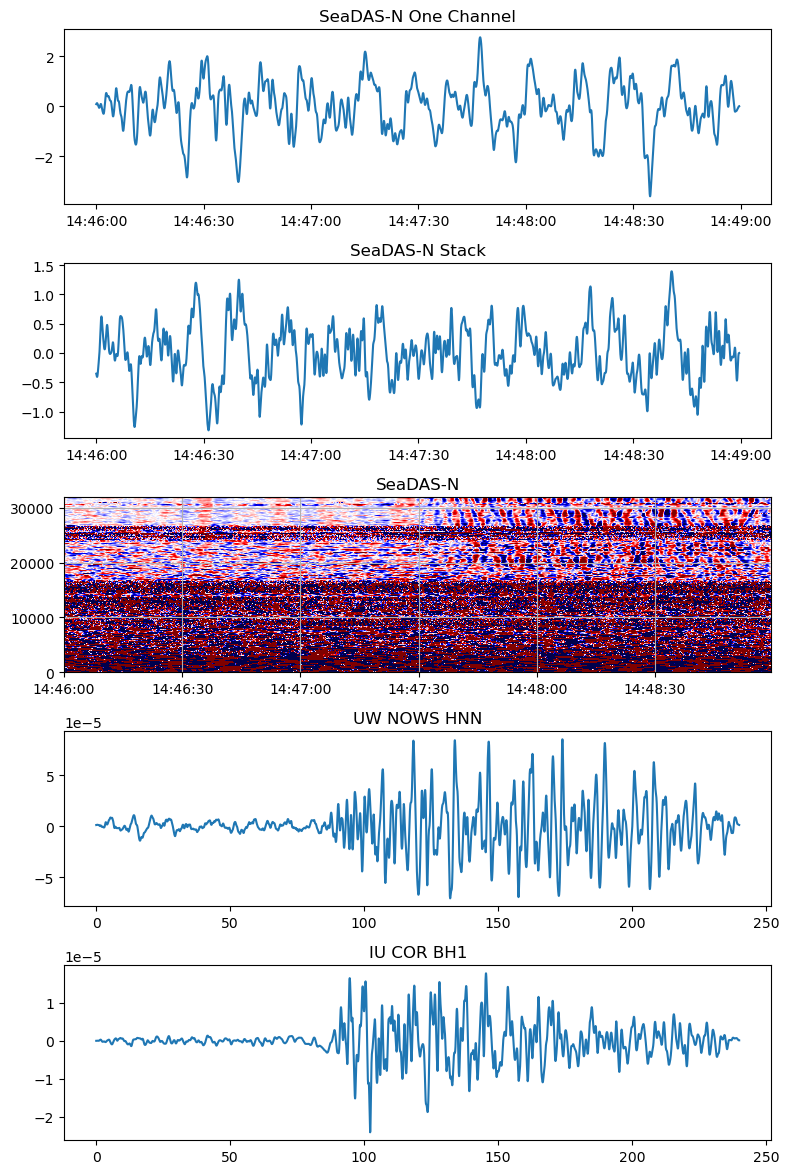

In [9]:
fig,ax=plt.subplots(figsize=(8,12))
plt.title(title,fontsize=12)

ax = plt.subplot(5,1,1)
fig.patch.set_facecolor('w')
# t = np.array([time-time[0]]).flatten()/1e6
plt.plot(dates,data_filt[:,100])
ax.set_title('SeaDAS-N One Channel')

ax = plt.subplot(5,1,2)
fig.patch.set_facecolor('w')
exx = np.mean(data_filt,axis=1)
# t = np.array([time-time[0]]).flatten()/1e6
plt.plot(dates,exx)
ax.set_title('SeaDAS-N Stack')

ax=plt.subplot(5,1,3)
ax.set_title('SeaDAS-N')
# plt.imshow(data_filt.T,vmin=-0.1,vmax=0.1,cmap='seismic',aspect='auto')
x_lims = mdates.date2num(dates)
plt.imshow(data_filt.T,vmin=-1,vmax=1,cmap='seismic',aspect='auto', extent=[x_lims[0],x_lims[-1],0,x_max])
ax.xaxis_date()
date_format = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(date_format)
plt.grid()

ax = plt.subplot(5,1,4)
for tr in st:
    plt.plot(tr.times(),tr.data)
fig.patch.set_facecolor('w')
ax.set_title('UW NOWS HNN')

ax = plt.subplot(5,1,5)
for tr in st2:
    plt.plot(tr.times(),tr.data)
fig.patch.set_facecolor('w')
ax.set_title('IU COR BH1')

fig.suptitle(title,fontsize=20)
plt.tight_layout()
plt.show()